In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_coro_1dm as fresnel
import apra_pop_models.rmad_1dm as rmad
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3


import lina
import lina.adefc as adefc
from scipy.optimize import minimize



/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.25


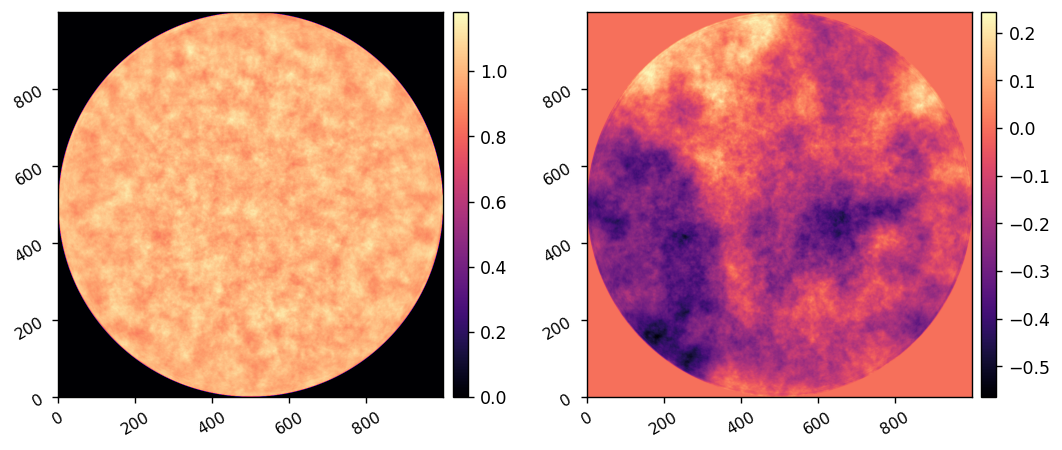

In [2]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

WFE = I.calc_pupil()
imshow2(xp.abs(WFE), xp.angle(WFE))

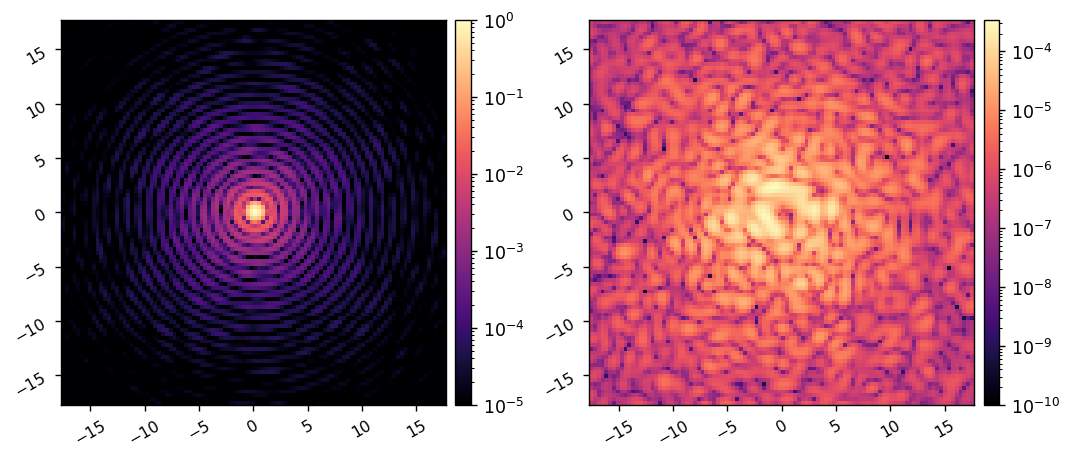

In [35]:
I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)


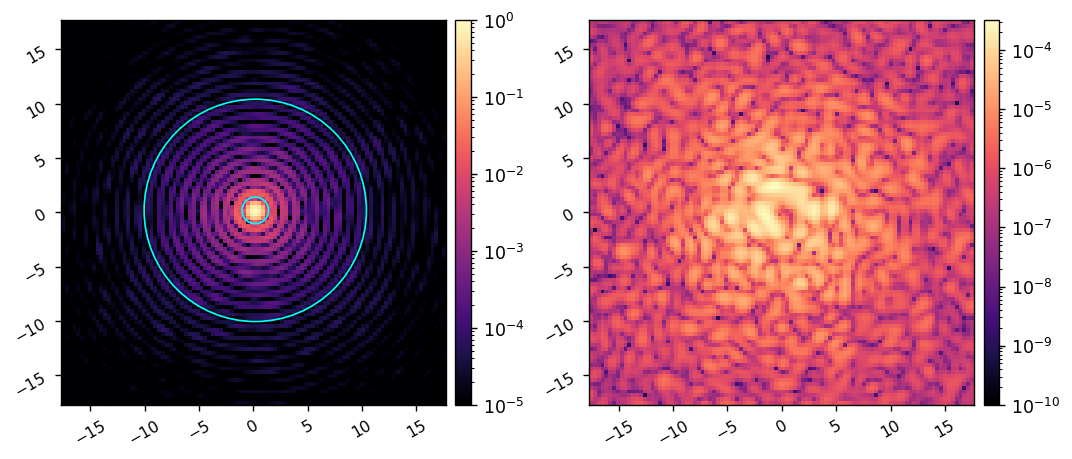

In [14]:
reload(rmad)
M = rmad.MODEL()
M.WFE = WFE
# M.WFE = xp.rot90(xp.rot90(WFE))

M.flip_dm = True
M.flip_lyot = True
# M.det_rotation = 180

acts = np.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, use_vortex=False) )**2
M.Imax_ref = xp.max(model_psf)
model_psf /= M.Imax_ref
model_coro_im = xp.abs( M.forward(acts, use_vortex=True) )**2

psf_center = (M.psf_pixelscale_lamD/2, M.psf_pixelscale_lamD/2)
imshow2(model_psf, model_coro_im, lognorm=True, vmin1=1e-5, vmin2=1e-10, 
        pxscl=M.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='cyan'), Circle(psf_center, 10.22, fill=False, color='cyan')])

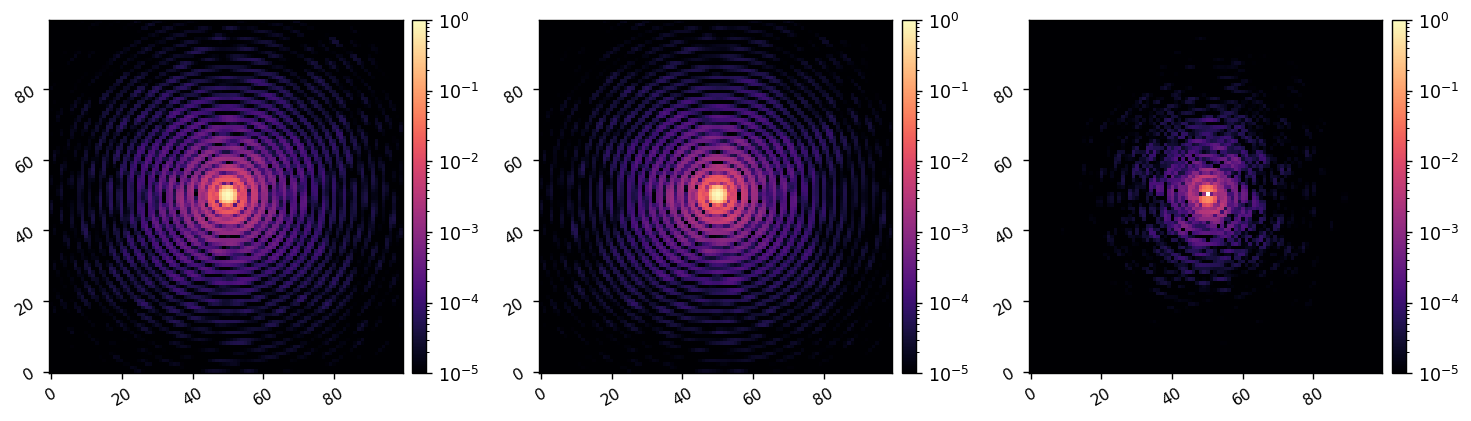

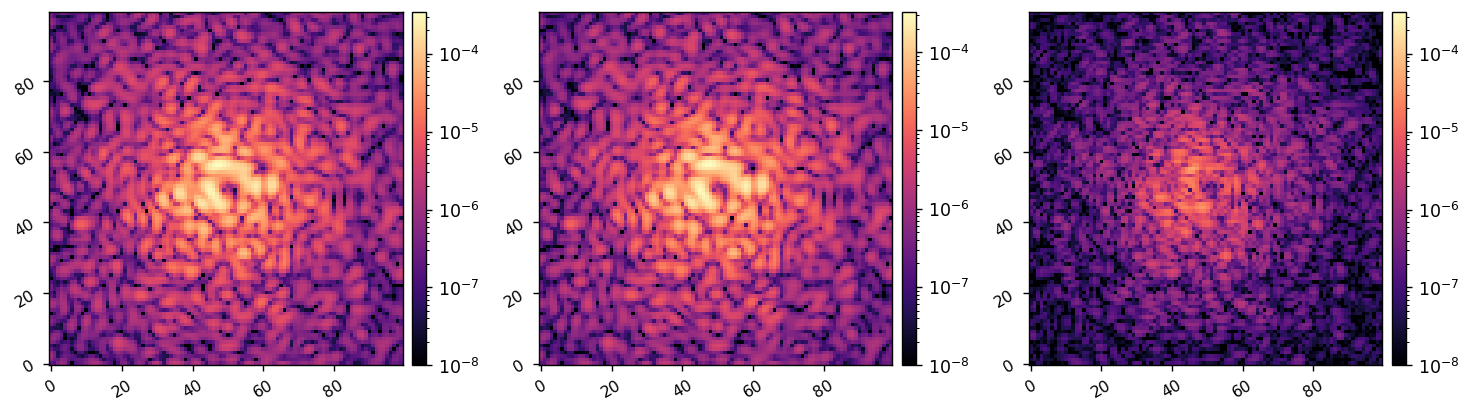

In [15]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

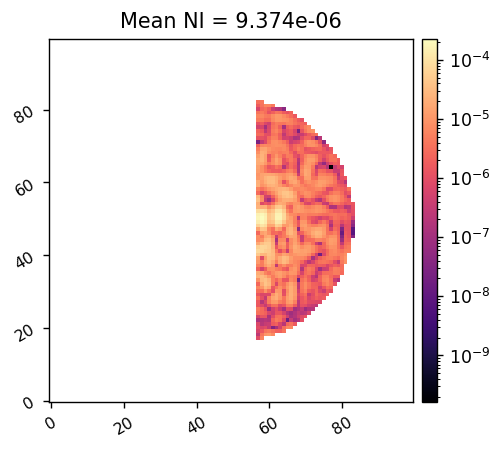

In [21]:

I.zero_dm()
iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)


	Cost-function J_delE: 0.012
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 1.000



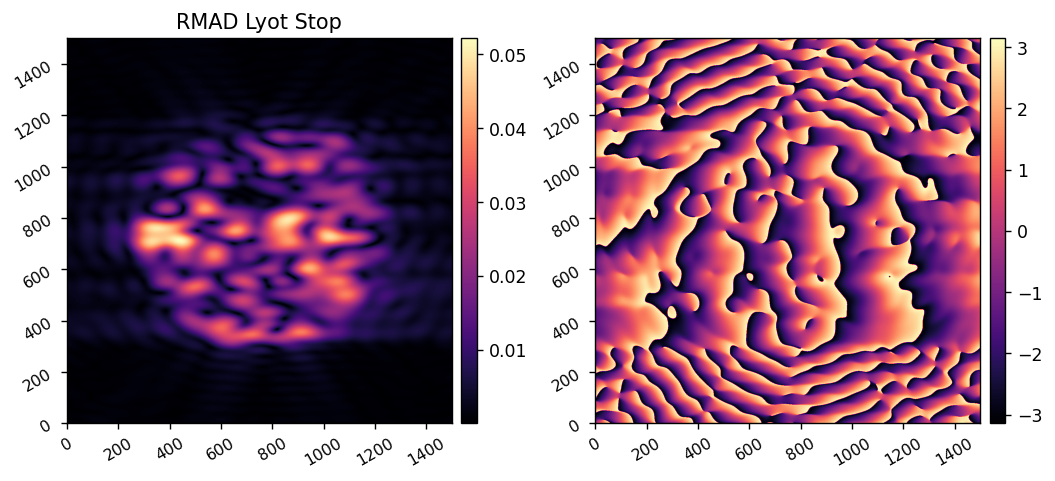

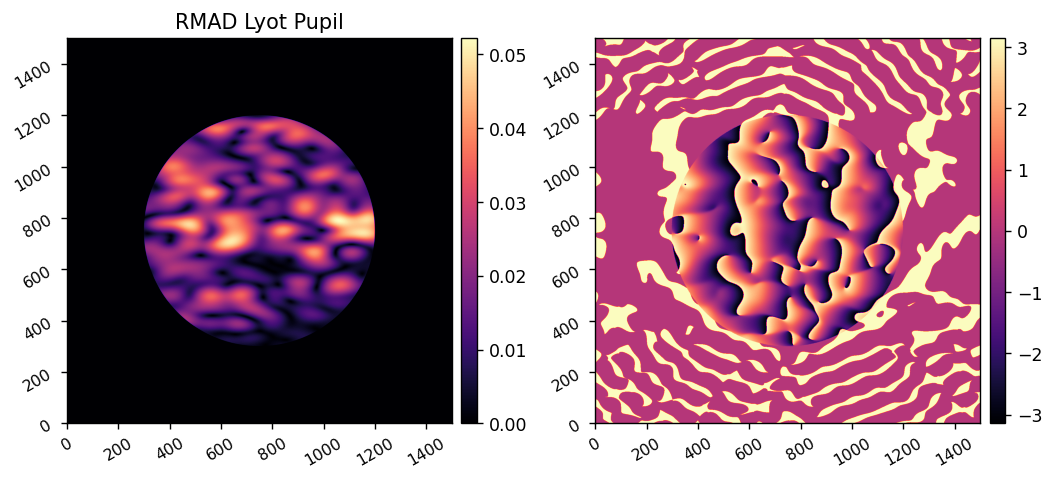

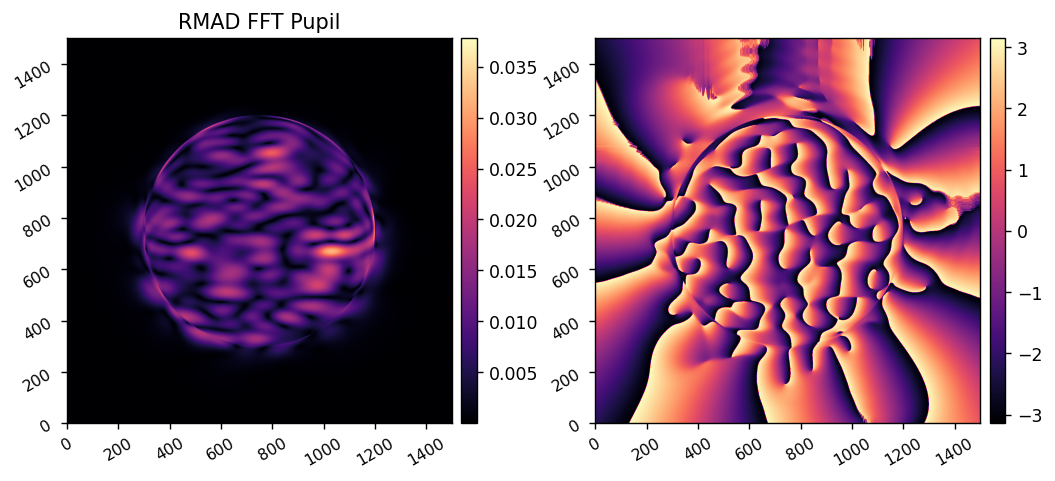

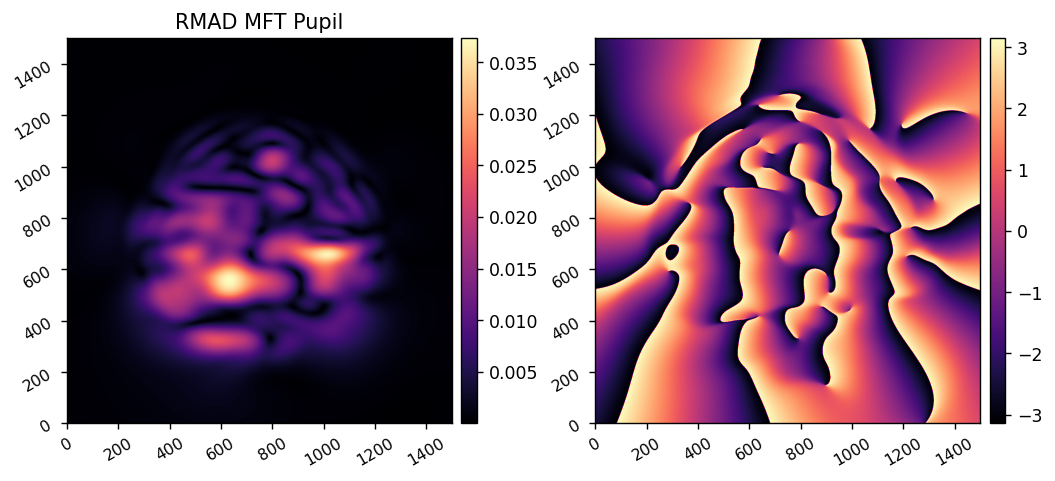

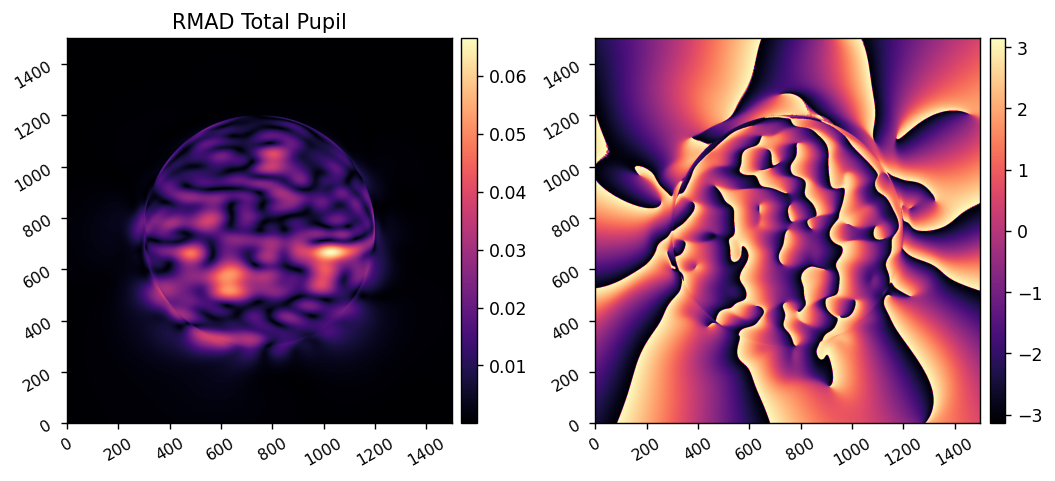

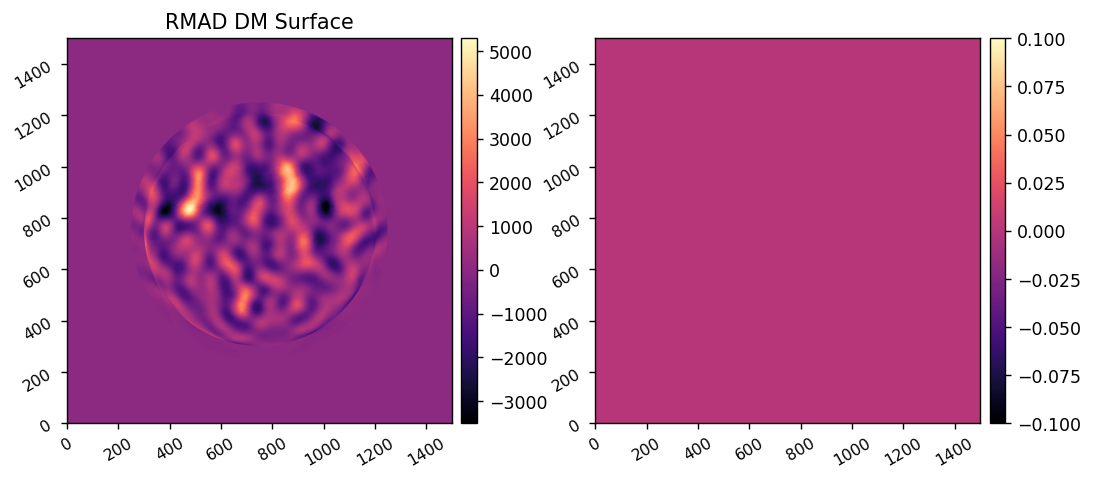

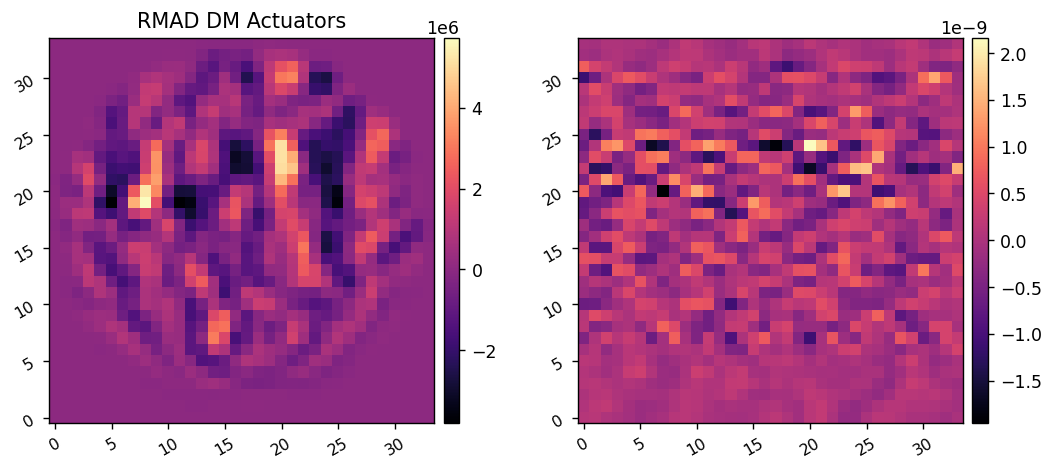

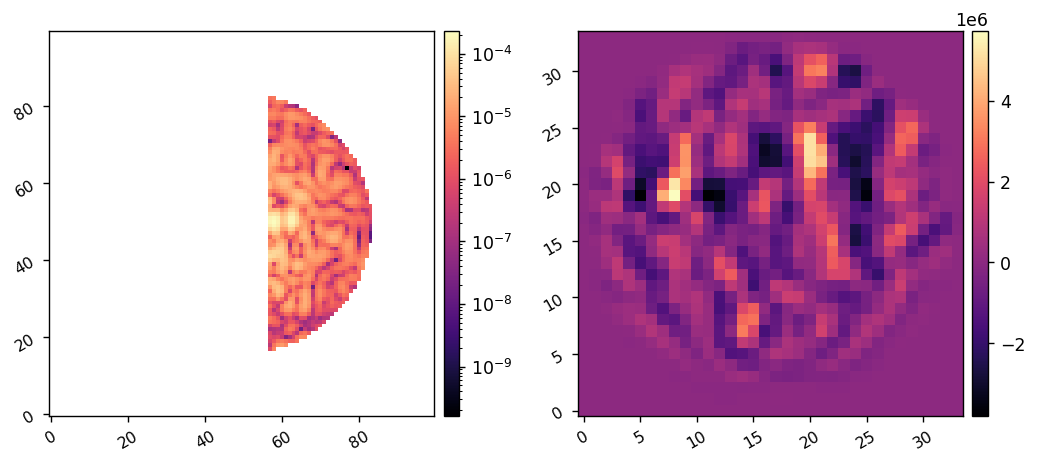

In [36]:
reload(rmad)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
r_cond = 1e-2

del_acts = np.zeros(M.Nacts)
J, dJ_dA = rmad.val_and_grad(del_acts, M, acts, E_ab, r_cond, control_mask, verbose=True, plot=True)

dm_grad = rmad.acts_to_command(dJ_dA, M.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [37]:

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')
I.set_dm(rmad.acts_to_command(acts, I.dm_mask))

E_ab = I.calc_wf() * control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(rmad.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, acts, E_ab, r_cond, control_mask, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


	Cost-function J_delE: 0.012
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  5.71196D+06
	Cost-function J_delE: 0.002
	Cost-function J_c: 2366863905.325
	Cost-function normalization factor: 0.012
	Total cost-function value: 190132590910.475

	Cost-function J_delE: 0.029
	Cost-function J_c: 2.407
	Cost-function normalization factor: 0.012
	Total cost-function value: 195.710

	Cost-function J_delE: 0.483
	Cost-function J_c: 0.142
	Cost-function normalization factor: 0.012
	Total cost-function value: 50.256

	Cost-function J_delE: 2.252
	Cost-function J_c: 0.010
	Cost-function normalization factor: 0.012
	Total cost-function value: 181.707



 This problem is unconstrained.


	Cost-function J_delE: 0.252
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 20.291

	Cost-function J_delE: 0.002
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 0.171


At iterate    1    f=  1.71095D-01    |proj g|=  1.45738D+06
	Cost-function J_delE: 0.001
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 0.078


At iterate    2    f=  7.79088D-02    |proj g|=  7.81470D+05
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 0.034


At iterate    3    f=  3.35151D-02    |proj g|=  3.22852D+05
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.012
	Total cost-function value: 0.021


At iterate    4    f=  2.05476D-02    |proj g|=  3.93605D+05
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization fa

9.373863936790468e-06 1.4657918111776852e-07


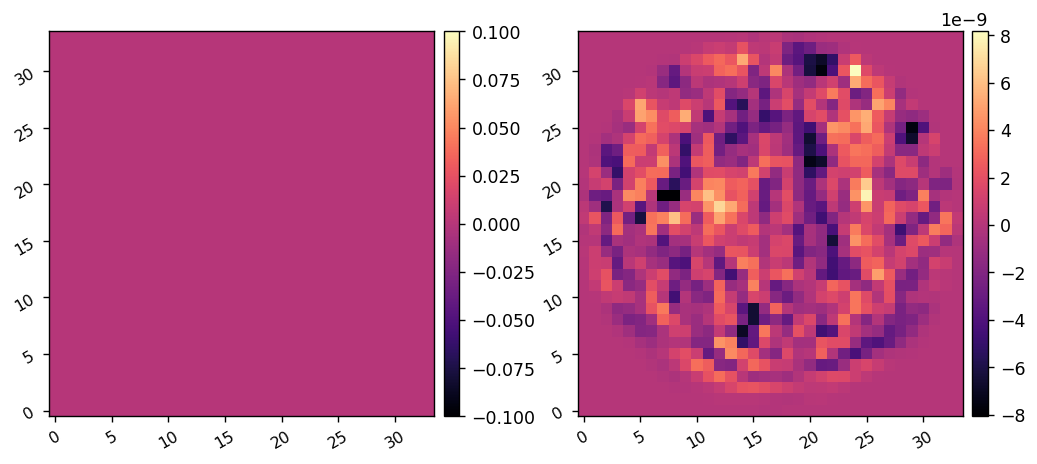

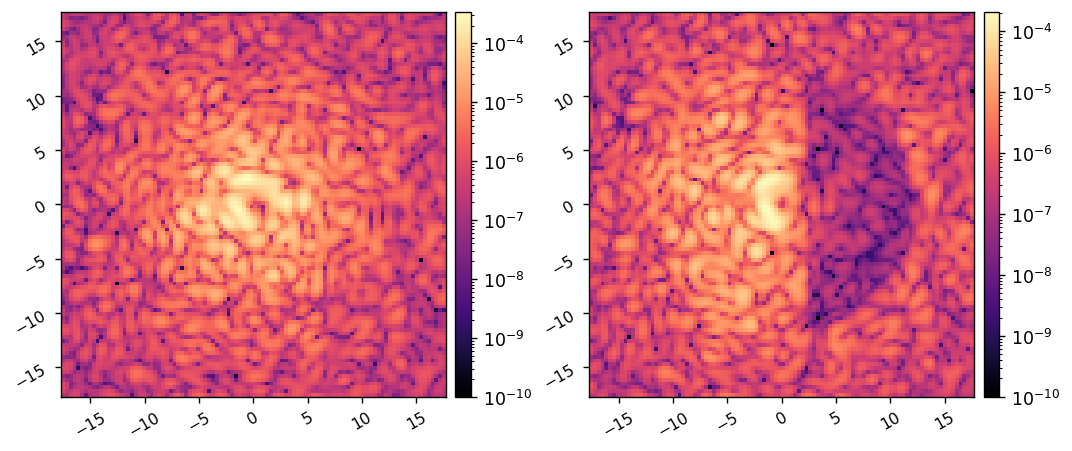

In [39]:
old_command = rmad.acts_to_command(acts, I.dm_mask)
del_command = rmad.acts_to_command(res.x, I.dm_mask)

I.set_dm(old_command)
old_im = I.snap()
I.set_dm(old_command + del_command)
new_im = I.snap()

print(xp.mean(old_im[control_mask]), xp.mean(new_im[control_mask]))
imshow2(old_command, del_command)
imshow2(old_im, new_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [29]:
utils.save_fits('example-data/ad_test_acts.fits', res.x)

Saved data to:  example-data/ad_test_acts.fits


In [25]:
I.zero_dm()
all_ims = []
all_efs = []
all_commands = []


Running estimation algorithm ...
Computing EFC command with L-BFGS


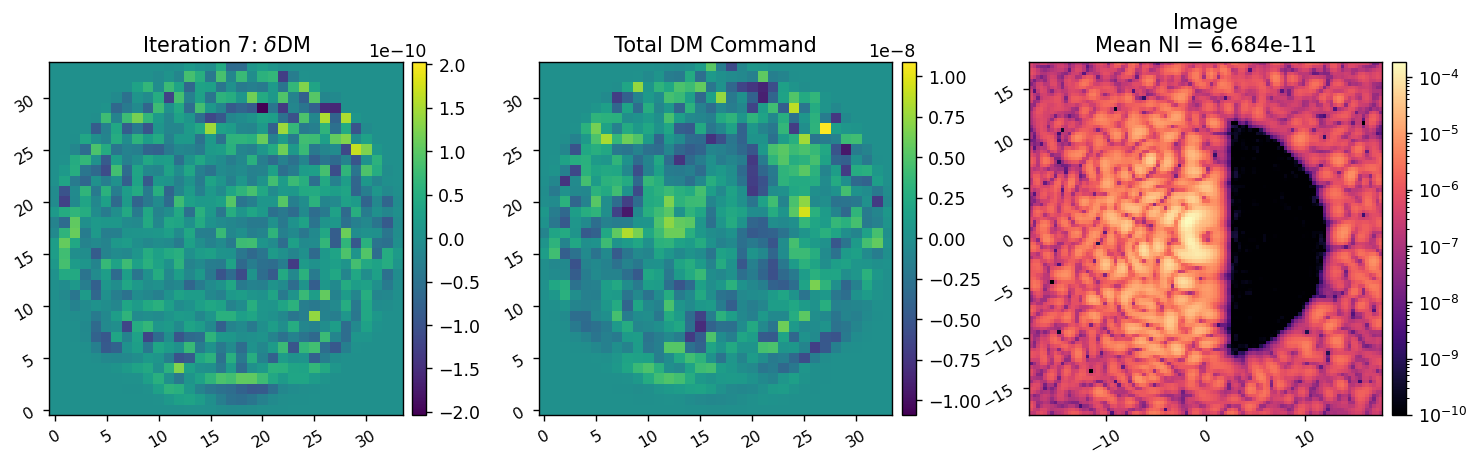

Running estimation algorithm ...
Computing EFC command with L-BFGS


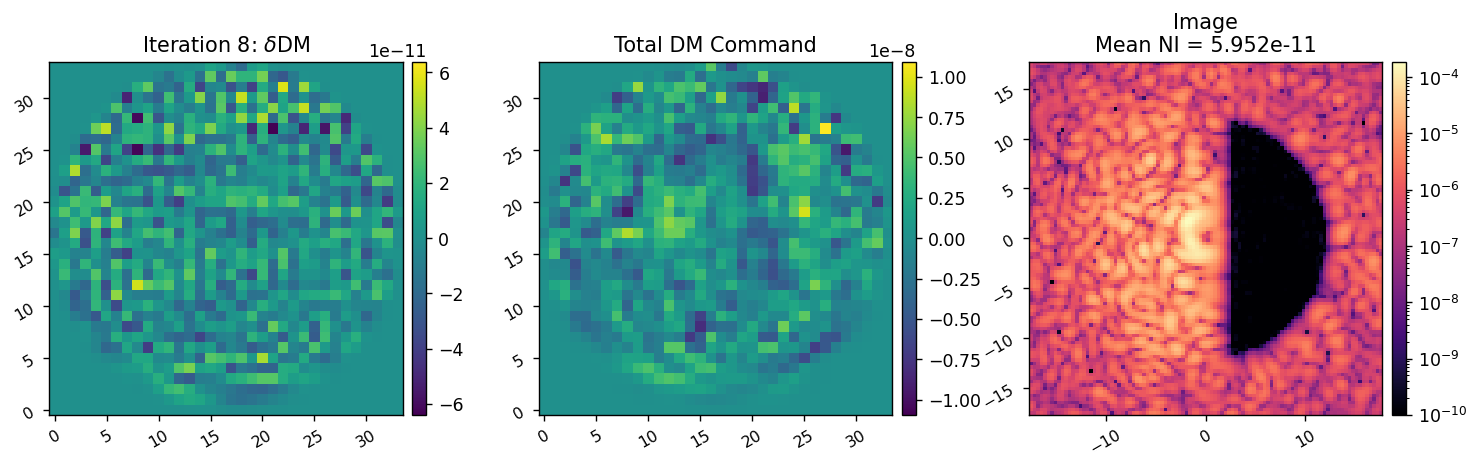

Running estimation algorithm ...
Computing EFC command with L-BFGS


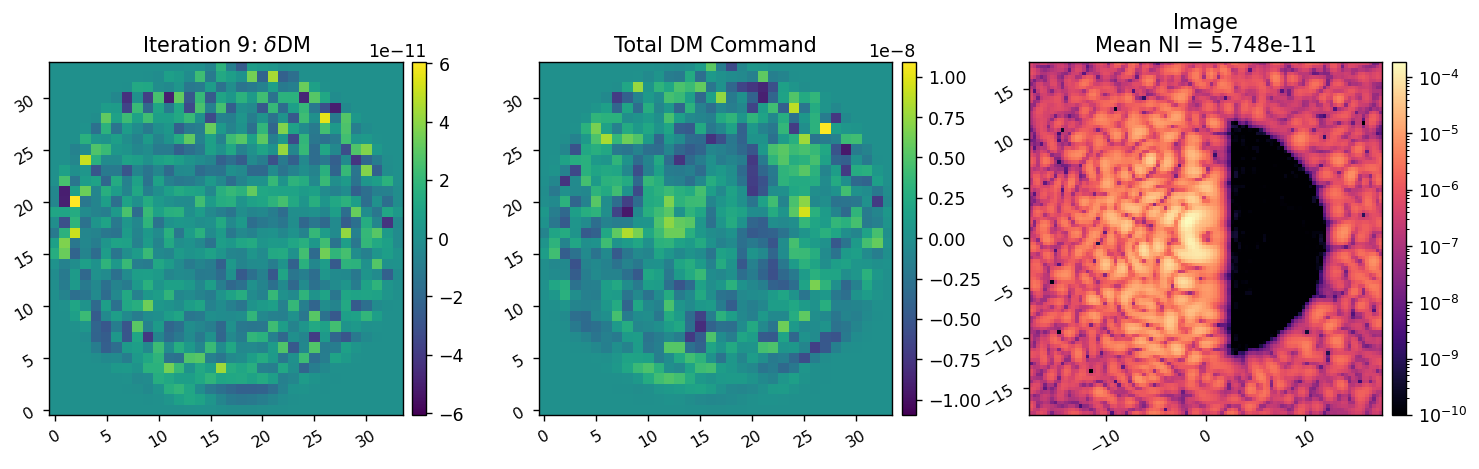

In [28]:
reload(rmad)
reload(adefc)

r_cond = 1e-2
r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = adefc.run(I, M, 
                                            rmad.val_and_grad, control_mask, 
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )